# Fit a Gaussian Process to AirBnB data, and plot it.

Author: Kui Tang

Final project for Statistical Graphics and Communication

## 0. 90% of Data Science is Getting and Cleaning the Data...

The files in http://insideairbnb.com/get-the-data.html under 'New York City' are saved under `data/`.

The `data/nybb_14aav.zip` file is downloaded from http://www.nyc.gov/html/dcp/download/bytes/nybb_14aav.zip.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import GPy

sns.set_style('white')


from IPython.core.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

RUN_DEAD_CODE = False
RUN_MODELS = True

listings_df = pd.read_csv('data/listings.csv.gz')
calendar_df = pd.read_csv('data/calendar.csv.gz')
neighbourhoods_df = pd.read_csv('data/neighbourhoods.csv')

boros_gdf = gpd.GeoDataFrame.from_file('data/nybb_14a_av/nybb.shp')
neighbourhoods_gdf = gpd.GeoDataFrame.from_file('data/neighbourhoods.geojson')

/Users/kuitang/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
 /Users/kuitang/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning:Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.


In [2]:
def clean_currency(x):
    x = str(x)
    if x[0] == '$':
        x = x[1:]
    x = x.replace(',', '')
    
    return float(x)

def clean_bool(x):
    return 1.0 if x == 't' else 0.0

def clean_percent(x):
    if np.isnan(x):
        return x
        
    x = str(x)
    if x[-1] == '%':
        x[-1] = ''
    
    return float(x) / 100.0
    
calendar_df['price'] = calendar_df['price'].apply(clean_currency)    
calendar_df['available'] = calendar_df['available'].apply(clean_bool)
calendar_df['date'] = pd.to_datetime(calendar_df.date)

cols_listings_currency = [u'price', u'weekly_price', u'monthly_price', u'security_deposit', u'cleaning_fee', u'extra_people']
for c in cols_listings_currency:
    listings_df[c] = listings_df[c].apply(clean_currency)
    
cols_listings_bool = ['is_location_exact', 'instant_bookable', 'host_identity_verified', 'host_is_superhost', 'host_has_profile_pic']
for c in cols_listings_bool:
    listings_df[c] = listings_df[c].apply(clean_bool)
    
cols_listings_cat = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
for c in cols_listings_cat:
    listings_df[c] = listings_df[c].astype('category')
    

In [3]:
def clean_percent(x):
    x = str(x)
    if x == 'nan':
        return x
    
    if x[-1] == '%':
        x = x[:-1]
    
    return float(x) / 100.0

listings_df['host_response_rate'].apply(clean_percent)

0        0.86
1         0.5
2         nan
3           1
4         nan
5           1
6         0.9
7           1
8           1
9        0.97
10       0.98
11       0.98
12       0.92
13       0.97
14          1
15       0.98
16       0.97
17          1
18       0.97
19       0.92
20          1
21          1
22          1
23          1
24          1
25          1
26       0.96
27          1
28        nan
29          1
         ... 
30453    0.93
30454    0.86
30455       1
30456     0.9
30457       1
30458     0.9
30459    0.93
30460       1
30461    0.25
30462    0.86
30463       1
30464    0.83
30465    0.45
30466    0.81
30467       1
30468     0.9
30469    0.88
30470     0.4
30471       1
30472    0.94
30473       1
30474     nan
30475     nan
30476     nan
30477    0.92
30478    0.69
30479    0.95
30480       1
30481    0.84
30482     nan
Name: host_response_rate, dtype: object

Eighty-eight percent of the lat-long locations are exact, so we can reasonably plot them.

In [4]:
listings_df['extra_people']

0         10
1          0
2          0
3          5
4         25
5         10
6         10
7          0
8          0
9         25
10         0
11        25
12        10
13        50
14         0
15        25
16         5
17        10
18         0
19        10
20        15
21         0
22        15
23         8
24        15
25         0
26        15
27        10
28         0
29         0
        ... 
30453      0
30454      0
30455      0
30456      0
30457     20
30458     50
30459     20
30460     10
30461      0
30462      0
30463      0
30464     15
30465     50
30466     50
30467      0
30468    100
30469      0
30470      0
30471     25
30472     20
30473      0
30474      0
30475      0
30476      0
30477      0
30478      0
30479      0
30480     30
30481     25
30482     25
Name: extra_people, dtype: float64

In [5]:
listings_df['is_location_exact'].mean()

0.8830495686120132

In [6]:
with pd.option_context('display.max_rows', 10000):
    print listings_df.dtypes

id                                     int64
listing_url                           object
scrape_id                              int64
last_scraped                          object
name                                  object
summary                               object
space                                 object
description                           object
experiences_offered                   object
neighborhood_overview                 object
notes                                 object
transit                               object
thumbnail_url                         object
medium_url                            object
picture_url                           object
xl_picture_url                        object
host_id                                int64
host_url                              object
host_name                             object
host_since                            object
host_location                         object
host_about                            object
host_respo

In [7]:
listings_df['availability_30']

0        12
1        30
2         0
3         1
4         0
5        12
6        11
7         0
8         6
9         4
10        0
11       25
12        2
13        7
14       13
15        1
16        9
17        0
18        3
19        6
20        0
21       11
22        0
23        6
24       12
25       30
26        0
27        7
28       26
29        1
         ..
30453    19
30454     0
30455     0
30456    19
30457     8
30458    11
30459     9
30460     1
30461     0
30462    30
30463     6
30464    15
30465    26
30466    16
30467     0
30468    30
30469     0
30470    30
30471    21
30472    10
30473     4
30474    25
30475     0
30476     5
30477     5
30478     9
30479     0
30480     9
30481    18
30482     0
Name: availability_30, dtype: int64

In [8]:
calendar_df

,listing_id,date,available,price
0,105,2015-09-01,1,549
1,105,2015-09-02,1,549
2,105,2015-09-03,1,549
3,105,2015-09-04,1,899
4,105,2015-09-05,1,899
5,105,2015-09-06,1,549
6,105,2015-09-07,1,549
7,105,2015-09-08,1,549
8,105,2015-09-09,1,549
9,105,2015-09-10,1,549


I'm not sure what this means. The spaces are never available to book? Everything's been booked up? At any rate, it should never be just one value. This must be a data error.

In [9]:
calendar_df['available'].mean()

0.6185066097923883

## 1. First Plot: Prices vs Location and Time

After viewing the results here, think of some covariates you could add to the Gaussian process.

### 1.1 Join calender and listing tables to obtain daily prices.

Some listings (a bit over 1%) show a zero for guests included! I really don't know how to deal with this other than to throw it out.

In [10]:
cols_listings_geo = ['latitude', 'longitude']
cols_listings_cont = ['host_listings_count', 'accommodates']

calendar_money_df = calendar_df[['listing_id', 'date', 'price']]
calendar_money_df = calendar_money_df[-calendar_money_df['price'].isnull()]

listings_money_cols = ['id'] + cols_listings_geo + cols_listings_cont + cols_listings_bool + cols_listings_cat + ['weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included']

listings_money_df = listings_df[listings_money_cols]
listings_money_df = listings_money_df[listings_money_df['guests_included'] > 0]

moneyloc_df = pd.merge(calendar_money_df, listings_money_df, how='inner', left_on=['listing_id'], right_on=['id'])
moneyloc_df['per_person_price'] = moneyloc_df['price'] / moneyloc_df['guests_included']
moneyloc_df['log_per_person_price'] = np.log(moneyloc_df['per_person_price'])

We indeed have location data for every listing, though recall it is not accurate for about 12%.

### 1.3 Plot the NYC Data

GeoPandas is **AMAZING**! It automatically displays even the polygon! I **love** technology! And in fact, according to the documnetation, it can even compute intersection and difference between two polygons. And it has area methods... whoa...

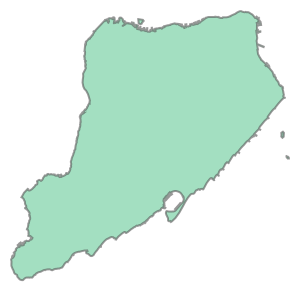

In [11]:
boros_gdf['geometry'][0]

Plotting the whole GeoDataFrame is not hard.

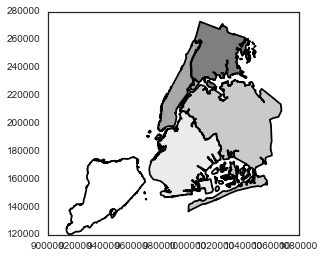

In [12]:
boros_gdf.plot()

In [13]:
boros_gdf.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

I need to read about coordinate systems. What controls the x and y axes?

For some reason, I know that converting to espg:4326 (what we read with the neighborhoods geojson file), the x and y axes are exactly lat and long, which means I can place points (as polygons) on the map.

Later, with the Gaussian processes, I will need to clip the predictions to land.

In [14]:
listings_df.ix[:100, 'latitude'].max()

40.868982953341387

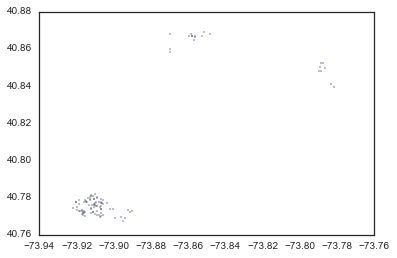

In [15]:
plt.scatter(
    listings_df.ix[:100, 'longitude'],
    listings_df.ix[:100, 'latitude'],
    s=2,
    marker='.')

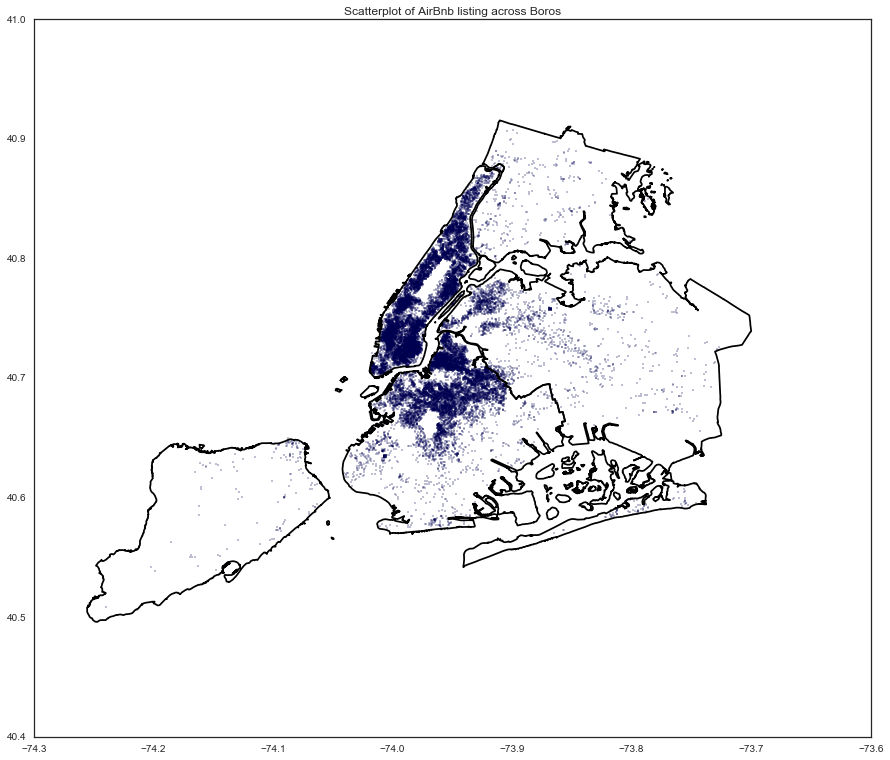

In [16]:
boros_epsg_gdf = boros_gdf.to_crs(epsg=4326)
boros_ax = boros_epsg_gdf.plot(alpha=0)
boros_ax.hold('on')
boros_ax.scatter(
    listings_df.ix[:, 'longitude'],
    listings_df.ix[:, 'latitude'],
    s=2,
    marker='.'
)

# It is always possible to resize the figure after the fact.

plt.gcf().set_size_inches(15, 15)
plt.title('Scatterplot of AirBnb listing across Boros')

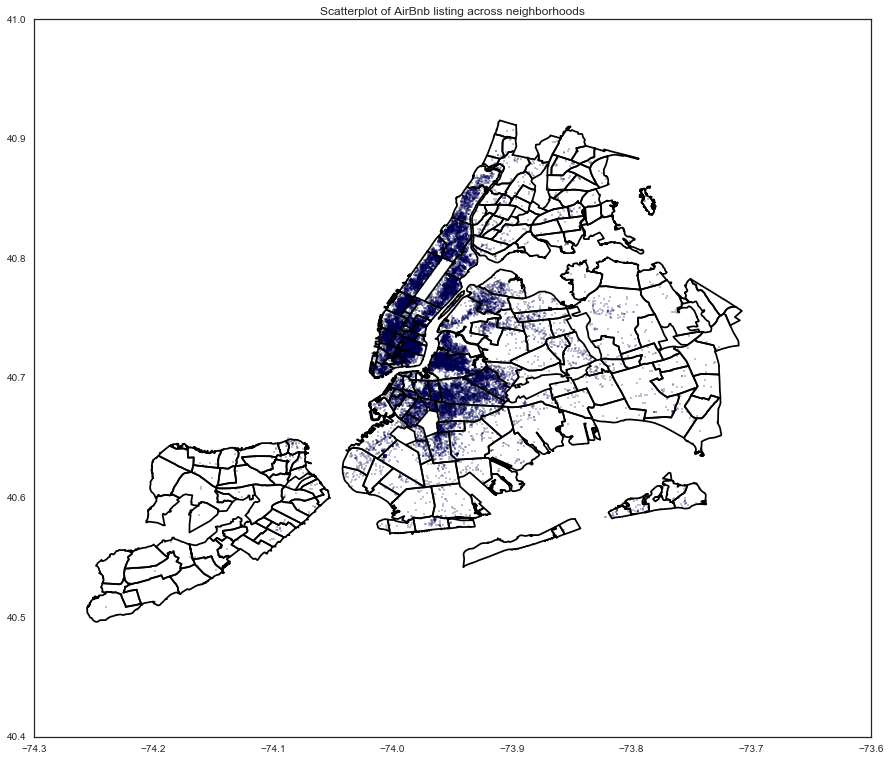

In [17]:
neighborhoods_ax = neighbourhoods_gdf.plot(alpha=0)
neighborhoods_ax.hold('on')
neighborhoods_ax.scatter(
    listings_df.ix[:, 'longitude'],
    listings_df.ix[:, 'latitude'],
    s=2,
    marker='.'
)

plt.gcf().set_size_inches(15, 15)
plt.title('Scatterplot of AirBnb listing across neighborhoods')

In [18]:
moneyloc_df

,listing_id,date,price,id,latitude,longitude,host_listings_count,accommodates,is_location_exact,instant_bookable,...,room_type,bed_type,cancellation_policy,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,per_person_price,log_per_person_price
0,105,2015-09-01,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
1,105,2015-09-02,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
2,105,2015-09-03,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
3,105,2015-09-04,899,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,449.5,6.108136
4,105,2015-09-05,899,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,449.5,6.108136
5,105,2015-09-06,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
6,105,2015-09-07,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
7,105,2015-09-08,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
8,105,2015-09-09,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951
9,105,2015-09-10,549,105,40.762099,-73.996022,3,7,1,0,...,Private room,Real Bed,flexible,5000,15000,NaN,NaN,2,274.5,5.614951


## 2. Figure out how to use GPy

Only plot the data for one day right now.

We fit two models: one to all of the variables we think could be predictive (which we have listed above), and another to just lat and long. The lat-long model is then suitable to plotting, while the full model can be used for prediction.

First we need to convert our dataframes into suitable design matrices, including 

In [19]:
import patsy

moneyloc_oneday_df = moneyloc_df[moneyloc_df['date'] == moneyloc_df['date'].min()]


loc_formula  = 'log_per_person_price ~ 1 + longitude + latitude'
full_formula = 'log_per_person_price ~ 1 + longitude + latitude + host_listings_count + instant_bookable + host_identity_verified + host_is_superhost + host_has_profile_pic + C(property_type) + C(room_type) + C(bed_type) + C(cancellation_policy)'

#moneyloc_oneday_scaled_df = moneyloc_oneday_df.copy()

#min_long = moneyloc_oneday_scaled_df['longitude'].min()
#min_lat = moneyloc_oneday_scaled_df['latitude'].min()
#range_long = moneyloc_oneday_scaled_df['longitude'].max() - min_long
#range_lat  = moneyloc_oneday_scaled_df['latitude'].max() - min_lat

# 
#moneyloc_oneday_scaled_df['longitude'] = (moneyloc_oneday_scaled_df['longitude'] - min_long) / range_long
#moneyloc_oneday_scaled_df['latitude'] = (moneyloc_oneday_scaled_df['latitude'] - min_lat) / range_lat

loc_dmat_logY, loc_dmat_X   = patsy.dmatrices(loc_formula, moneyloc_oneday_df)
full_dmat_logY, full_dmat_X = patsy.dmatrices(full_formula, moneyloc_oneday_df)

Log-transforming the Y variable is necessary due to its heavy tail.

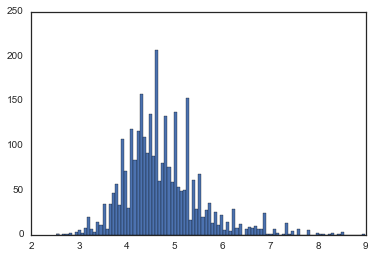

In [20]:
plt.hist(np.ravel(loc_dmat_logY), bins=100)
None

### 2.1 Fit baseline linear regression models

Even a simple linear model will capture much of the variation. Thus, we should include a linear kernel in our GP model.

In [21]:
loc_lm = sm.OLS(loc_dmat_logY, loc_dmat_X)
loc_lm_results = loc_lm.fit()
loc_lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_per_person_price   R-squared:                       0.118
Model:                              OLS   Adj. R-squared:                  0.117
Method:                   Least Squares   F-statistic:                     198.6
Date:                  Mon, 07 Dec 2015   Prob (F-statistic):           1.08e-81
Time:                          14:05:04   Log-Likelihood:                -3395.9
No. Observations:                  2980   AIC:                             6798.
Df Residuals:                      2977   BIC:                             6816.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -577.8120     29.277    -19.736      0.000      -635.217  -520.407
longitude     -6.5461      0.344    -19.010      0.000        -7.221    -5.871
latitude       2.4157      0.259      9.338      0.000         1.908     2.923
==============================================================================
Omnibus:                      595.655   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1490.824
Skew:                           1.088   Prob(JB):                         0.00
Kurtosis:                       5.697   Cond. No.                     1.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

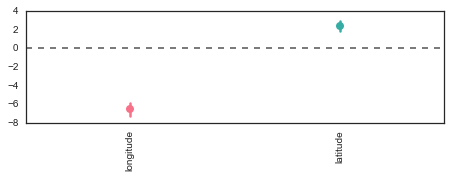

In [22]:
sns.coefplot(loc_formula, moneyloc_oneday_df)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)
None

In [23]:
full_lm = sm.OLS(full_dmat_logY, full_dmat_X)
full_lm_results = full_lm.fit()
full_lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_per_person_price   R-squared:                       0.292
Model:                              OLS   Adj. R-squared:                  0.285
Method:                   Least Squares   F-statistic:                     43.46
Date:                  Mon, 07 Dec 2015   Prob (F-statistic):          1.71e-197
Time:                          14:05:04   Log-Likelihood:                -3068.0
No. Observations:                  2980   AIC:                             6194.
Df Residuals:                      2951   BIC:                             6368.
Df Model:                            28                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
Intercept                                  -458.1700     28.318    -16.179      0.000      -513.695  -402.645
C(property_type)[T.Bed & Breakfast]           0.1265      0.111      1.144      0.253        -0.090     0.343
C(property_type)[T.Cabin]                     0.0315      0.682      0.046      0.963        -1.305     1.368
C(property_type)[T.Camper/RV]                -0.3809      0.393     -0.968      0.333        -1.152     0.391
C(property_type)[T.Condominium]               0.6263      0.206      3.041      0.002         0.223     1.030
C(property_type)[T.Dorm]                     -0.0483      0.395     -0.122      0.903        -0.823     0.726
C(property_type)[T.House]                    -0.0404      0.045     -0.906      0.365        -0.128     0.047
C(property_type)[T.Lighthouse]               -0.4554      0.682     -0.667      0.505        -1.793     0.882
C(property_type)[T.Loft]                      0.1006      0.083      1.216      0.224        -0.062     0.263
C(property_type)[T.Other]                     0.8770      0.192      4.560      0.000         0.500     1.254
C(property_type)[T.Tent]                      0.0448      0.682      0.066      0.948        -1.292     1.381
C(property_type)[T.Townhouse]                -0.1604      0.190     -0.845      0.398        -0.532     0.212
C(property_type)[T.Treehouse]                -0.6025      0.684     -0.880      0.379        -1.944     0.740
C(room_type)[T.Private room]                 -0.5438      0.027    -20.069      0.000        -0.597    -0.491
C(room_type)[T.Shared room]                  -0.6705      0.067     -9.983      0.000        -0.802    -0.539
C(bed_type)[T.Couch]                          0.0820      0.206      0.398      0.691        -0.322     0.486
C(bed_type)[T.Futon]                          0.1605      0.163      0.986      0.324        -0.159     0.480
C(bed_type)[T.Pull-out Sofa]                  0.1206      0.170      0.709      0.479        -0.213     0.454
C(bed_type)[T.Real Bed]                       0.1909      0.139      1.371      0.171        -0.082     0.464
C(cancellation_policy)[T.moderate]           -0.3397      0.036     -9.355      0.000        -0.411    -0.268
C(cancellation_policy)[T.strict]             -0.3942      0.029    -13.542      0.000        -0.451    -0.337
C(cancellation_policy)[T.super_strict_60]     2.4373      0.482      5.052      0.000         1.491     3.383
longitude                                    -5.2170      0.329    -15.848      0.000        -5.862    -4.572
latitude                                      1.9021      0.242      7.846      0.000         1.427     2.378
host_listings_count                        3.814e-05      0.001      0.026      0.979      

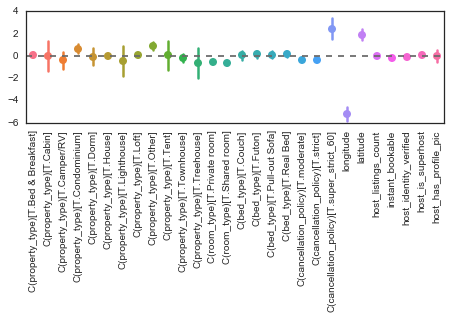

In [24]:
sns.coefplot(full_formula, moneyloc_oneday_df)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)
None

The fit is statistically significant, but has low $R^2$.

(array([   23.,   234.,   918.,  1028.,   511.,   143.,    72.,    34.,
           12.,     5.]),
 array([ 2.52572864,  3.17187546,  3.81802228,  4.4641691 ,  5.11031591,
         5.75646273,  6.40260955,  7.04875637,  7.69490319,  8.34105   ,
         8.98719682]),
 <a list of 10 Patch objects>)

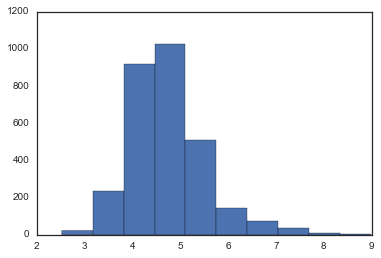

In [25]:
plt.hist(np.ravel(loc_dmat_logY))

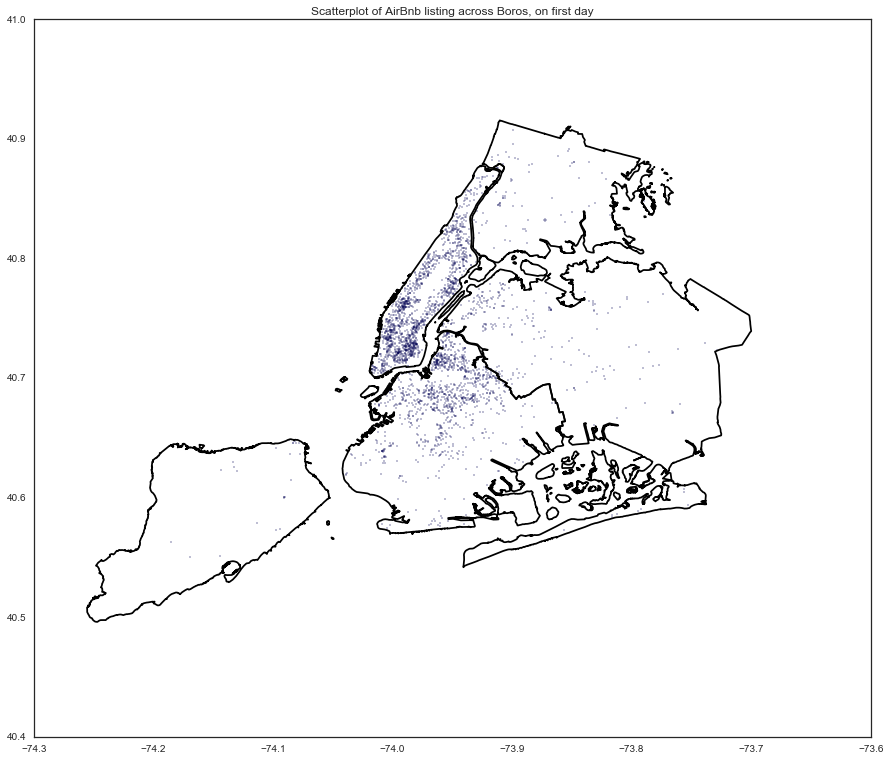

In [26]:
boros_oneday_ax = boros_epsg_gdf.plot(alpha=0)
boros_oneday_ax.hold('on')
boros_oneday_ax.scatter(
    moneyloc_oneday_df.ix[:, 'longitude'],
    moneyloc_oneday_df.ix[:, 'latitude'],
    s=2,
    marker='.'
)

# It is always possible to resize the figure after the fact.

plt.gcf().set_size_inches(15, 15)
plt.title('Scatterplot of AirBnb listing across Boros, on first day')

### 2.2 Fit the Gaussian process

In [165]:
# Copied from the example

# CONCLUSION: Choose linear + Matern.

def sparse_GP_regression_2D(X, Y, num_inducing=500, max_iters=100, optimize=True, plot=True):
    """Run a 2D example of a sparse GP regression."""
#    np.random.seed(1234)

    # construct kernel
    n_cols = X.shape[1]
    kern = GPy.kern.Linear(n_cols).add(GPy.kern.Matern32(n_cols))
#    rbf = GPy.kern.Linear(2).add(GPy.kern.RatQuad(2))


    # create simple GP Model    
#    m = GPy.models.GPRegression(X, Y, kernel=kern, noise_var=1)
    m = GPy.models.SparseGPRegression(X, Y, kernel=kern, num_inducing=num_inducing)

    # contrain all parameters to be positive (but not inducing inputs)
    m['.*len'] = 2.

    m.checkgrad()

    # optimize
    if optimize:
        m.optimize('tnc', messages=1, max_iters=max_iters)
#        m.optimize(messages=1, max_iters=max_iters)
        

    # plot
    if plot:
        try:
            m.plot()
        except Exception as e:
            print "Unable to plot because ", e

    print(m)
    return m



The conclusion for sparse GP is that you need 500 inducing points compared to 3000 full points to get a good fit. (100 inducing points is not enough.)


Name                              : sparse gp
Log-likelihood                    : -3197.1980145
Number of Parameters              : 14004
Number of Optimization Parameters : 14004
Updates                           : True
Parameters:
  sparse_gp.               |      Value       |  Constraint  |  Prior  |  Tied to
  inducing inputs          |       (500, 28)  |              |         |         
  sum.linear.variances     |  0.998844939878  |     +ve      |         |         
  sum.Mat32.variance       |  0.790291824982  |     +ve      |         |         
  sum.Mat32.lengthscale    |   3.27053589079  |     +ve      |         |         
  Gaussian_noise.variance  |  0.450845903414  |     +ve      |         |         

Name                              : sparse gp
Log-likelihood                    : -3202.52710661
Number of Parameters              : 1004
Number of Optimization Parameters : 1004
Updates                           : True
Parameters:
  sparse_gp.               |      Value  

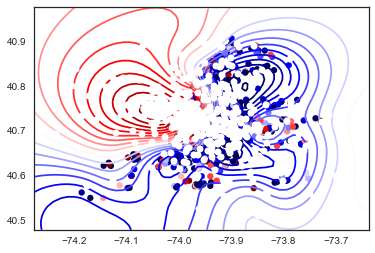

In [166]:
import save

if RUN_MODELS:
    # The first column in the intercept, which is necessary for the linear model but not necessary for the GPy because it automatically normalizes.
    full_model_oneday = sparse_GP_regression_2D(full_dmat_X[:,1:], full_dmat_logY, plot=False)
    loc_model_oneday  = sparse_GP_regression_2D(loc_dmat_X[:,1:], loc_dmat_logY, plot=True)
    
    save.save(
        'FirstLook_models.pkl',
        comment="Saving loc_model_oneday results.",
        loc_model_oneday=loc_model_oneday,
        full_model_oneday=full_model_oneday)

else:
    saved_model = save.load('FirstLook_predictions.pkl')

    loc_model_oneday = saved_model['loc_model_oneday']
    full_model_oneday = saved_model['full_model_oneday']

Presentation note: Discuss the isochromic and diverging colormaps.

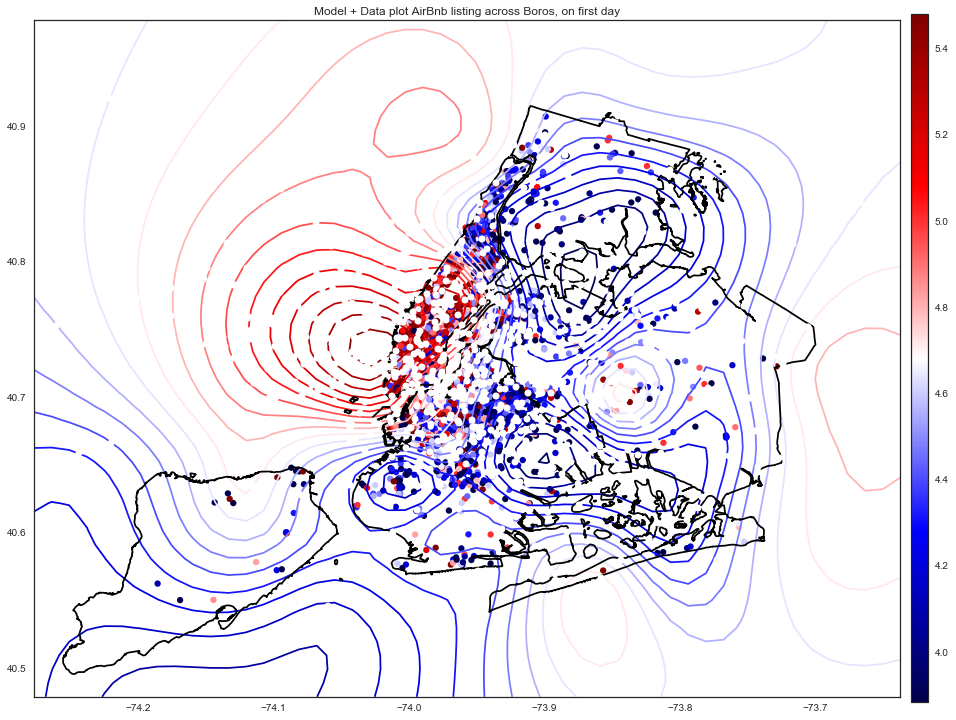

In [159]:
boros_oneday_ax = boros_epsg_gdf.plot(colormap='binary', alpha=0)
boros_oneday_ax.hold('on')
plots = loc_model_oneday.plot(ax=boros_oneday_ax)
plt.title('Model + Data plot AirBnb listing across Boros, on first day')
plt.colorbar(plots['dataplot'],
             orientation='vertical',
             pad=0.01,
             shrink=0.65,
             aspect=40)
plt.gcf().set_size_inches(15, 15)
plt.tight_layout()
#plt.colorbar()
#loc_model_oneday.plot??
#boros_oneday_ax.colorbar(orientation='horizontal')

### 2.2 Quantitatively evaluate predictions

In [160]:
def eval_model_fit(model, X, Y):
    Yhat, Yhatvar = model.predict(X)
    resids = Yhat - Y
    mse_resids = np.mean(np.square(resids))
    mse_total = np.mean(np.square(Y - np.mean(Y)))

    return {
        'rmse': float(np.sqrt(mse_resids)),
        'Rsq': float(1 - (mse_resids / mse_total))
    }

In [161]:
import pprint
print "Location-only model evaluation:"
pprint.pprint(eval_model_fit(loc_model_oneday, loc_dmat_X[:,1:], loc_dmat_logY))
print "Full model evaluation:"
pprint.pprint(eval_model_fit(full_model_oneday, full_dmat_X[:,1:], full_dmat_logY))


Location-only model evaluation:
{'Rsq': 0.2660478393534672, 'rmse': 0.689754258217147}
Full model evaluation:
{'Rsq': 0.3471045055037053, 'rmse': 0.6505524989438884}


### 2.3 Draw the predictions

In [32]:
from GPy.plotting.matplot_dep.base_plots import gpplot, x_frame2D

In [33]:
loc_dmat_X[:,1:].min(0)

array([-74.18563361,  40.55073404])

In [162]:
#raise Exception("StopIt.")

from matplotlib import animation

resolution = 200
#resolution = 100

# This part is *really* slow.
def predict_grid(model, X, resolution, full_cov=False):
    Xgrid, xx, yy, xmin, xmax = x_frame2D(X, resolution=resolution)
    
    # For use in the image map
    extent = [xmin[0], xmax[0], xmin[1], xmax[1]]
    
    # Full covariance is too slow.
    m, v = model.predict(Xgrid, full_cov=full_cov)
    dmu_dx, dv_dx = model.predictive_gradients(Xgrid)
    # Row/column major silliness
    return m, v, dmu_dx, dv_dx, extent, Xgrid

m, v, dmu_dx, dv_dx, extent, Xgrid = predict_grid(loc_model_oneday, loc_dmat_X[:,1:], resolution=resolution, full_cov=True)

KeyboardInterrupt: 

In [68]:
len(m)

10000

Predictions are expensive, so we save the results.

In [69]:
import save
save.save(
    'FirstLook_predictions.pkl',
    comment="Saving loc_model_oneday results and m, v extent are predictions for the loc model with diagonal covariance, because full covariance is too expensive.",
    loc_model_oneday=loc_model_oneday,
    full_model_oneday=full_model_oneday,
    m=m,
    v=v,
    extent=extent)

The complexity, as a function of spatial resolution, is really $O(N^6)$.

In [70]:
v.shape

(10000, 10000)

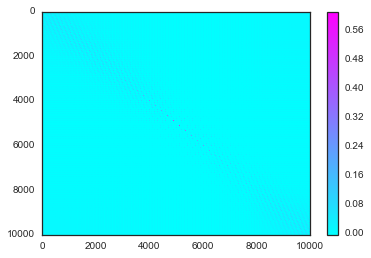

In [71]:
plt.imshow(v, aspect='auto', cmap='cool')
plt.colorbar()

In [72]:
np.diag(v)

array([ 0.61242688,  0.61234104,  0.61224947, ...,  0.61294567,
        0.61296328,  0.61298044])

In [73]:
np.mean(v)

0.0073803804127190306

In [74]:
v.size

100000000

In [75]:
np.sqrt(   np.sum(np.diag(v)) / v.shape[0]   )

0.75958837749361652

In [76]:
np.sqrt(   (np.sum(v) - np.sum(np.diag(v))) / (v.size - v.shape[0])   )

0.085576955449040634

(array([  9.85848800e+07,   1.35826800e+06,   4.68520000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.84000000e+02,   2.36800000e+03,
          7.34800000e+03]),
 array([-0.00319256,  0.05842474,  0.12004204,  0.18165934,  0.24327664,
         0.30489394,  0.36651124,  0.42812854,  0.48974584,  0.55136314,
         0.61298044]),
 <a list of 10 Patch objects>)

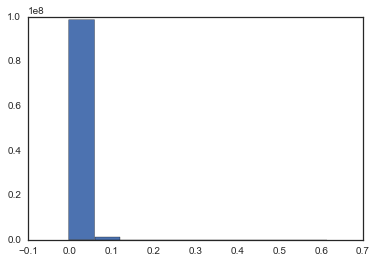

In [77]:
plt.hist(np.ravel(v))

The main expense in sampling is running SVD on the v matrix, so we may as well use more samples.

Sampling... this part will take a long time...
clim is (2.4350894140019279, 6.919443476792976)


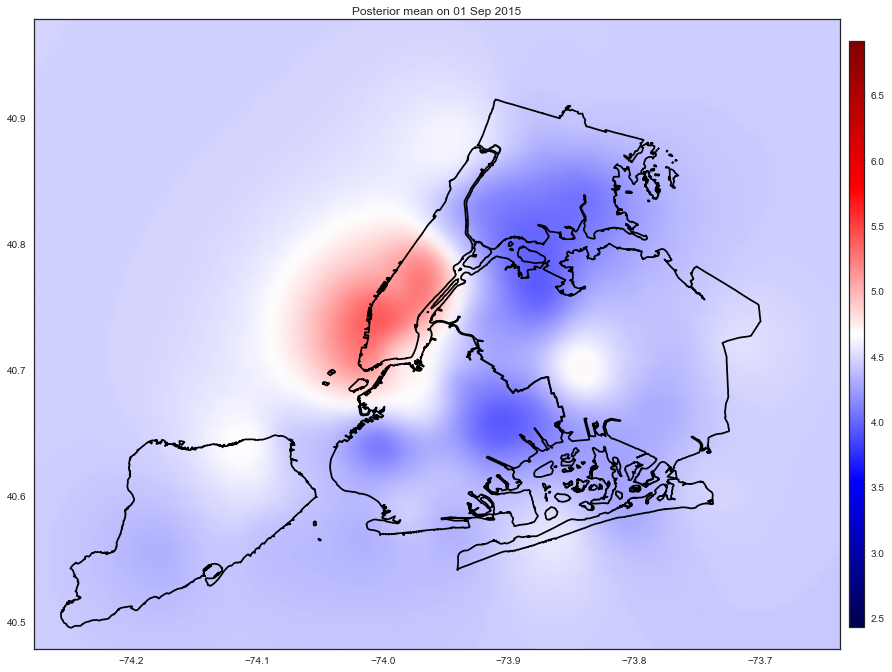

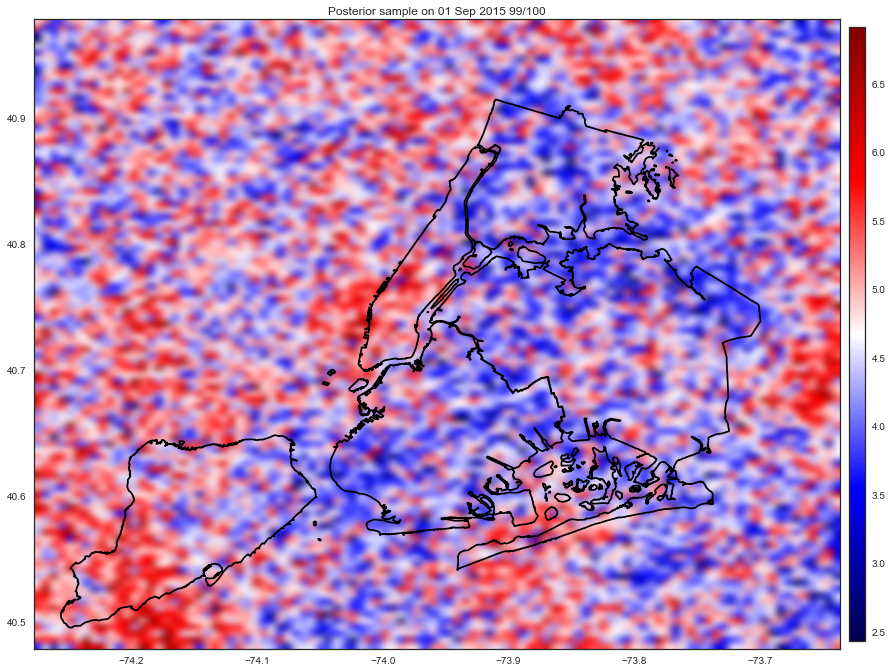

In [79]:
def plot_imgmaps(data_date, m, v, resolution, extent, gdf, n_samples=100, figsize=(15,15), cmap='seismic', animate=True):
    date_str = data_date.strftime('%d %b %Y')
    m_img = m.reshape(resolution, resolution).T
#    v_img = v.reshape(resolution, resolution).T

#    import pdb; pdb.set_trace()
    
    # Sample
#    samples = np.random.normal(m[:,0], np.sqrt(v[:,0]), size=(n_samples, len(m))).T    
    print "Sampling... this part will take a long time..."
    samples = np.random.multivariate_normal(m[:,0], v, size=n_samples).T    
    sample_imgs = samples.reshape(resolution, resolution, n_samples).swapaxes(0,1)
    
    # Find the upper and lower bounds of all numbers.
#    cmin = np.min([np.min(m_img), np.min(np.sqrt(v_img)), np.min(sample_imgs)])
#    cmax = np.max([np.max(m_img), np.max(np.sqrt(v_img)), np.max(sample_imgs)])

    cmin = np.min(samples)
    cmax = np.max(samples)

#    cmin = np.min(m)
#    cmax = np.max(m)

    clim = (cmin, cmax)    
    
    # Two sigmas ought to be enough for anybody
    median_sd = np.sqrt(np.median(np.diag(v)))
    clim = (np.min(m) - 1.96*median_sd,
            np.max(m) + 1.96*median_sd)

    print "clim is %s" % (clim,)

    # This is deficient...
#    clim = np.min(m), np.max(m)
    
#    import pdb; pdb.set_trace()
    
    # See http://stackoverflow.com/questions/6999621/how-to-use-extent-in-matplotlib-pyplot-imshow
    # extent=[horizontal_min,horizontal_max,vertical_min,vertical_max
    
    def _plot(img, clim=None, cmap=cmap, fig=None, title='',):
        if fig is None:
            fig = plt.figure()
        # Plot the map first, because we rely on its package to draw stuff.
        gdf_ax = gdf.plot(colormap='binary', alpha=0)    
        gdf_ax.hold('on')

        # Plot our GP of evaluated listings prices    
        # TODO: Plot simulation (waves...)

        im = plt.imshow(img,
                   origin='lower',
                   interpolation='bicubic',
                   cmap=cmap,
                   alpha=1,
                   extent=extent,
                   clim=clim)    
        plt.colorbar(            
            orientation='vertical',
            pad=0.01,
            shrink=0.65,
            aspect=40)
        plt.title(title)
        plt.tight_layout()
        plt.gcf().set_size_inches(*figsize)                
        return fig, im
    
    # TODO: Unify the color
    _plot(m_img, clim=clim, title='Posterior mean on ' + date_str)    
    plt.savefig('work/mean_gp.pdf', bbox_inches='tight', pad_inches=0)
    
#    _plot(np.sqrt(v_img), title='Std', cmap='hot')
        
    # Init
    #fig, im = _plot(sample_imgs[:,:,0])        
    
    anim = None
    if animate:    
        # For some reason FuncAnimation just doesn't work on Mac and IPython notebook.
        # In fact, it also doesn't work on plain Python. Must be something about your
        # setup. But ArtistAnimation works so we use that.

        fig = plt.figure()

        gdf_ax = gdf.plot(colormap='binary', alpha=0)    
        gdf_ax.hold('on')    

        ims = []    
        for n in xrange(n_samples):
    #        print "Animating frame %d / %d" % (n, n_samples)
            im = plt.imshow(sample_imgs[:,:,n],
                            origin='lower',
                            interpolation='bicubic',
                            cmap=cmap,
                            extent=extent,
                            clim=clim)

            # Try bicubic vs Gaussian?
            # Note that since we used a Matern kernel, it is not really Gaussian smoothing (which implies RBF)

    #        print im
            ims.append([im])

        plt.colorbar(            
            orientation='vertical',
            pad=0.01,
            shrink=0.65,
            aspect=40)        
        plt.tight_layout()
        plt.gcf().set_size_inches(*figsize)
        plt.title('Posterior sample on %s %d/%d' % (date_str, n, n_samples))

        anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
        anim.save('work/anim_samples.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

        plt.show()
        
#    return m_img, v_img, sample_imgs, anim
    return m_img, sample_imgs, anim


m_img, sample_imgs, anim = plot_imgmaps(moneyloc_oneday_df['date'].min(),
                                        m, v, resolution, extent, boros_epsg_gdf,
                                        n_samples=100, figsize=(15,15))

### 2.4 Stationary Points

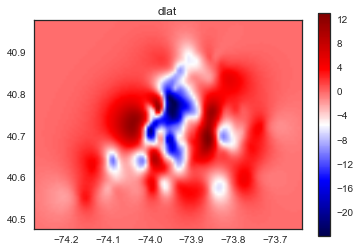

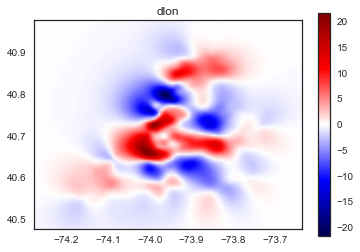

In [88]:
dmu_dlat_img = dmu_dx[:,0,0].reshape(resolution, resolution).T
dmu_dlon_img = dmu_dx[:,1,0].reshape(resolution, resolution).T

plt.figure()
plt.imshow(dmu_dlat_img, origin='lower', extent=extent, cmap='seismic')
plt.title('dlat')
plt.colorbar()

plt.figure()
plt.imshow(dmu_dlon_img, origin='lower', extent=extent, cmap='seismic')
plt.title('dlon')
plt.colorbar()

Plot the norm of the gradient. This is a way to see the gentrification frontier: a dark region is a region where of rapid change in price.

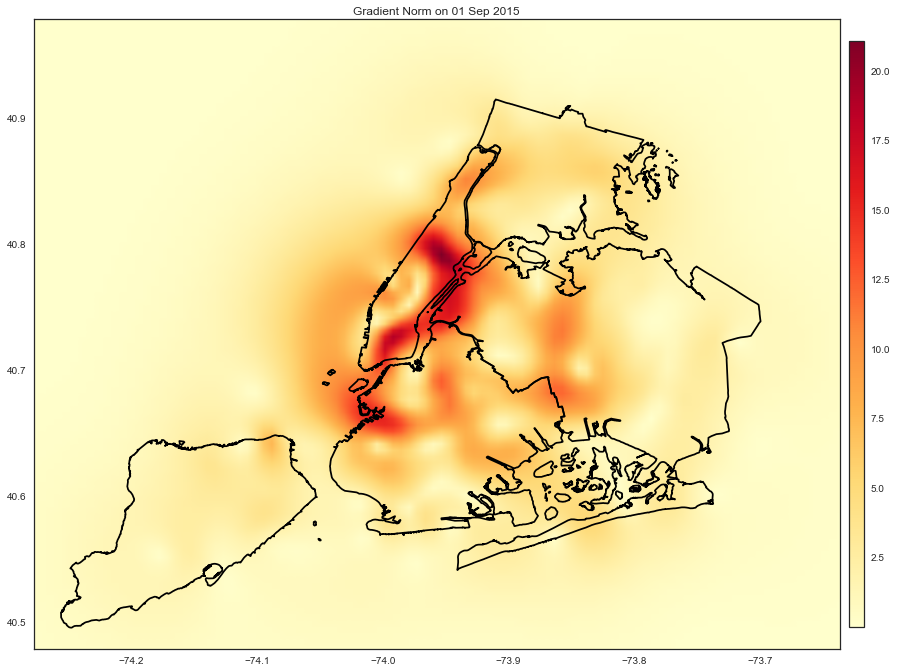

In [154]:
data_date_str = moneyloc_oneday_df['date'].min().strftime('%d %b %Y')

gdf_ax = boros_epsg_gdf.plot(colormap='binary', alpha=0)    
gdf_ax.hold('on')

grad_norm = np.sqrt(np.mean(np.square(dmu_dx[:,:,0]), axis=1))

grad_norm_img = grad_norm.reshape(resolution, resolution).T
#plt.figure()
plt.imshow(grad_norm_img,
           origin='lower',
           extent=extent,
           cmap='YlOrRd')
plt.title('Gradient Norm on ' + data_date_str)
plt.colorbar(pad=0.01,
             shrink=0.65,
             aspect=40)
plt.tight_layout()
plt.gcf().set_size_inches((15,15))
plt.savefig('work/grad_norm_gp.pdf', bbox_inches='tight', pad_inches=0)

### 2.5 Neighborhoods of Stationary Points

How quickly do the gradients grow?

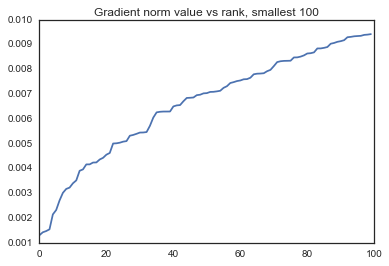

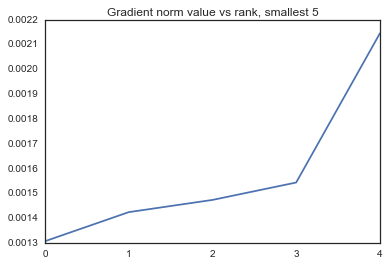

In [140]:
plt.figure()
plt.plot(np.sort(grad_norm)[:100])
plt.title('Gradient norm value vs rank, smallest 100')

plt.figure()
plt.plot(np.sort(grad_norm)[:5])
plt.title('Gradient norm value vs rank, smallest 5')
plt.xticks(np.arange(5))
None

Abandoned the attempt to further dig into stationary points, as that didn't get anywhere.

In [149]:
k = 500
top_k_inds = np.argsort(np.ravel(grad_norm_img))[:k]
top_k_inds

array([7308, 7007, 7107, 6806, 7509, 7208, 6906, 6605, 7710, 7409, 6505,
       6706, 7408, 7610, 7207, 7798, 7911, 7609, 6705, 6907, 7811, 6304,
       7006, 7810, 6404, 9867, 8012, 6405, 8112, 6204, 7108, 9768, 7797,
       8213, 8011, 7698, 7309, 6805, 6606, 6504, 8414, 8313, 7508, 7307,
       7510, 7709, 6103, 8314, 6003, 8113, 7898, 6104, 8515, 7711, 7912,
       8212, 7106, 6203, 8615, 7910, 8716, 7697, 6807,   83, 7897, 8514,
       6305, 5903, 6604, 8817, 8616, 9018, 6905, 9668, 8917, 9967, 9119,
       8111, 6303, 8413, 8816, 8415, 8918, 7008, 9320, 9421, 9220, 9219,
       7608, 7407, 9522, 8715, 6004, 6506, 5803,   84, 8214, 7809, 9118,
       8717, 9622, 9723, 7206, 9321, 9019, 8312, 6704, 9623, 9521, 9824,
       5802, 5902, 7209, 6403, 9017, 8614, 8013, 8010, 9420, 6002, 5702,
       9925, 7005, 9422, 7410, 9924, 9724, 7812, 8516, 9823, 8916, 9868,
       6205, 9319, 7611, 9120, 7998, 8818, 9722, 8513, 8211, 6707, 6102,
       9218, 5703, 5602, 6503, 8815, 7997, 7507, 96

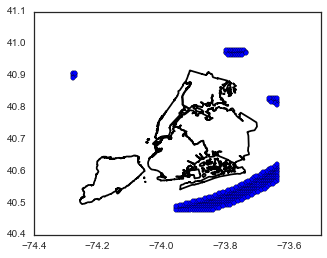

In [150]:
gdf_ax = boros_epsg_gdf.plot(colormap='binary', alpha=0)    
gdf_ax.hold('on')

plt.scatter(Xgrid[top_k_inds,0], Xgrid[top_k_inds,1])

In [131]:
Xgrid[top_5_inds,:]

array([[-73.80530131,  40.51972457],
       [-73.82468718,  40.51467651],
       [-73.81822522,  40.51467651],
       [-73.83761109,  40.50962846],
       [-73.7923774 ,  40.52477262]])